# Machine Learning Final Project - Mark Peters

# Theory Questions:

## 1.1 Difference Between Classification and Regression problems:

There are two types of supervised learning. Classification is used to predict the label, or category, of an observation. For example, we can predict whether an incoming mail is spam or not. As there are only two outcomes here - spam or not-spam - this is known as binary classification. Regression is used to predict continuous values. For example, a model can use features such as the density of a population, the countries GDP, education, access to healthcare, plus a host of other variables to predict the general health and projected lifespan of an average person in that population.

## 1.2 What is Supervised Learning?

I'll start by giving a definition of its opposite, Unsupervised Learning is the process of uncovering hidden patterns and structures from unlabeled data. The main difference between supervised and unsupervised learning is this 'labelling'. 

Supervised learning is a type of machine learning where the values to be predicted are already known, and a model is built with the aim of accurately predicting values of previously unseen data. Supervised learning uses features to predict the value of a target variable in the case of a regression problem, or the category of an observation in a classification problem.

The easiest to understand and the most commonly used model in everyday examples is 'Linear Regression' where a straight line is used to predict future observations based on the best 'fit' (by reducing the residuals) for the data. There are many other models available, these are the ones we used during this course: Logistic Regression, Decision Trees, Random Forest, Support Vector Machines (SVM), and K-Nearest Neighbors (KNN).

RMSE (root-mean-squared-error) is a measure of the difference between the actual and predicted values of an observation. Above I mentioned residuals, these are the individual differences between value and prediction. RMSE is the measure of the standard deviation of the residuals. The residuals are squared, added together and we then find the square root of the result. This evaluation model works for regression problems but won't help with classification.

For that we might use a 'Confusion Matrix'. This is a great way to evaluate the performance of a model on classification tasks. Simply put, it is a square matrix showing True Positives (FP), False Negatives (FN), True Negatives (TN), and False Negatives. We can then use these values to calculate the accuracy, precision, recall and f1 scores and so judge the efficacy of our model.

As an aside, my way of understanding the 'False' values is to say "False 'when you said' Negative". A little awkward maybe, but it helps me.

## Analysis of MNIST Dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, cross_val_score
from scipy.stats import reciprocal, uniform
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

c:\Users\makpe\.virtualenvs\Machine_Learning-2CwZjeYm\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# EDA (Exploratory Data Analysis)

In [166]:
print(mnist['DESCR'])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [6]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

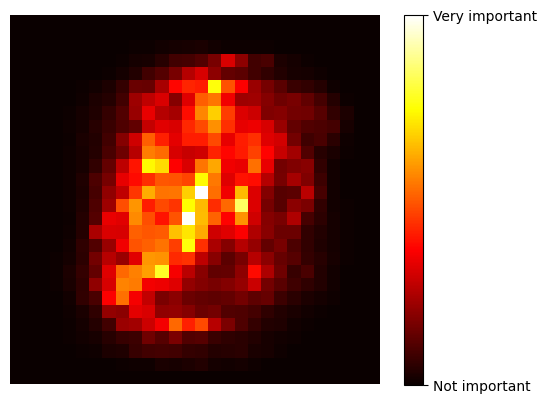

In [7]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

This is a simple model that shows maps the most common commonly used pixels in MNIST

In [18]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [19]:
X.shape

(70000, 784)

In [27]:
y.shape

(70000,)

I split the data into three groups so that I would have an untouched set for testing at the very end of my experimentation.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


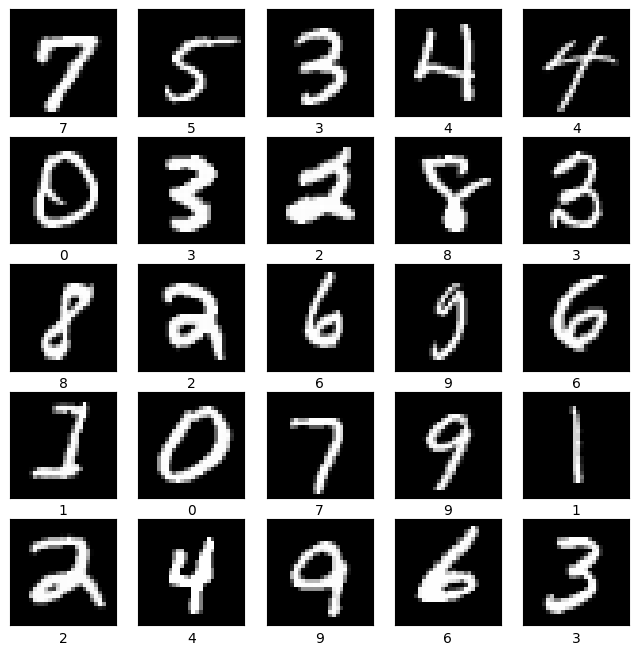

In [9]:
import matplotlib.pyplot as plt

# Plot the first 25 images in the training set
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i].reshape(28, 28), cmap='gray')
    axi.set(xticks=[], yticks=[], xlabel=y_train[i])


In [10]:

# Convert the target arrays to a Pandas Series
y_train_series = pd.Series(y_train)

# Count the number of samples in each class
class_counts = y_train_series.value_counts()


A quick table to show how the total number of each digit is not the same

In [11]:
print(class_counts)

1    4676
7    4363
3    4292
2    4235
9    4186
4    4146
0    4136
8    4107
6    4101
5    3758
dtype: int64


Text(0, 0.5, 'Number of Samples')

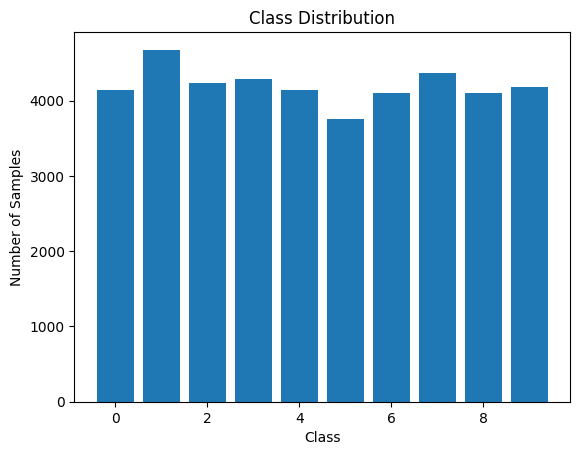

In [44]:
# Plot the class distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')


## Scaling the Data

In [12]:
# Standardizing the data (as you always should do when using SVM models).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)  # Only transforming the test data. 

# Linear SVC Model

LinearSVC is a linear support vector machine (SVM) implementation in scikit-learn. It learns the linear decision boundaries between classes in the training data by maximizing the margin between the closest data points of different classes. It then uses a hinge loss function to train the model, which penalizes misclassifications with a linear function. 

It is particularly useful when dealing with large classification datasets like MNIST.

In [13]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_val_scaled, y_val)

c:\Users\makpe\.virtualenvs\Machine_Learning-2CwZjeYm\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

In [14]:
y_pred_linear = lin_clf.predict(X_val_scaled)
accuracy_lvc = accuracy_score(y_val, y_pred_linear)
print('Accuracy: ', accuracy_lvc)

Accuracy:  0.9544285714285714


Even though I'm using the entire dataset in my modelling, I have broken it into three groups - train, val, and test - which has reduced the wait time by a large margin.

In [16]:
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

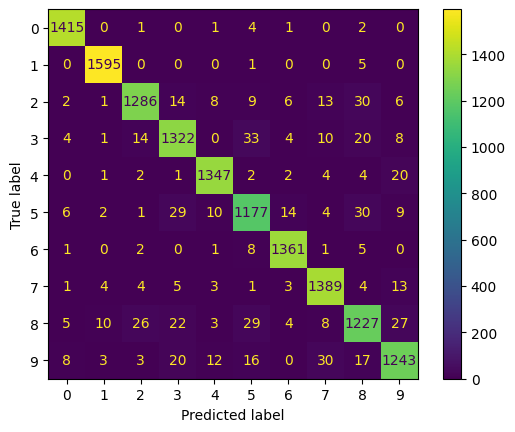

In [17]:
display_confusion_matrix(y_val, y_pred_linear)

Although this is a copy of what you gave us in class, I wanted to see what the return would be like if I used the entire dataset (other than having to wait for 8 mins for the LinearSCV to fit the data).

It is clear that the reason why '5' is often chosen as the target digit is that it is the most difficult to predict, so therefore the most interesting to study.

## Mulitclass model of all digits in the MNIST dataset

In [18]:
svm_clf = SVC(kernel='rbf', gamma='auto')
svm_clf.fit(X_train_scaled, y_train)

SVC(gamma='auto')

In [19]:
y_pred = svm_clf.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
print('accuracy: ', accuracy)

accuracy:  0.9622857142857143


# Choosing a Digit to search for

The book decides to single out the number '5' as its search target. I've decided to go with number '2'. As can be seen in the earlier confusion matrix, it isn't as problematic as 5 but it is well represented in many columns which means it gets confused with many other digits (albeit not that often).

In [20]:
y_train_2 = (y_train == 2) # True for all 2s, False for all other digits
y_val_2 = (y_val == 2)
y_test_2 = (y_test == 2)

# SGD Classifier

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_2)

SGDClassifier(random_state=42)

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_2, cv=3, scoring="accuracy")

array([0.9665    , 0.97142857, 0.94564286])

In [23]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3)
print(confusion_matrix(y_train_2, y_train_pred))

[[36542  1223]
 [  407  3828]]


In [24]:
print(classification_report(y_train_2, y_train_pred))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98     37765
        True       0.76      0.90      0.82      4235

    accuracy                           0.96     42000
   macro avg       0.87      0.94      0.90     42000
weighted avg       0.97      0.96      0.96     42000



In [25]:
precision_sgd = precision_score(y_train_2, y_train_pred)
print('precision score: ', precision_sgd)

precision score:  0.7578697287665809


## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train_2)
y_pred_2 = logreg.predict(X_val_scaled)

c:\Users\makpe\.virtualenvs\Machine_Learning-2CwZjeYm\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
y_pred_2_probs = logreg.predict_proba(X_val)[:, 1]
print(y_pred_2_probs[:10])

[1.00000000e+000 0.00000000e+000 5.87529897e-272 1.00000000e+000
 1.00893723e-135 2.96720385e-125 5.24065754e-107 0.00000000e+000
 3.43308449e-174 4.99864622e-277]


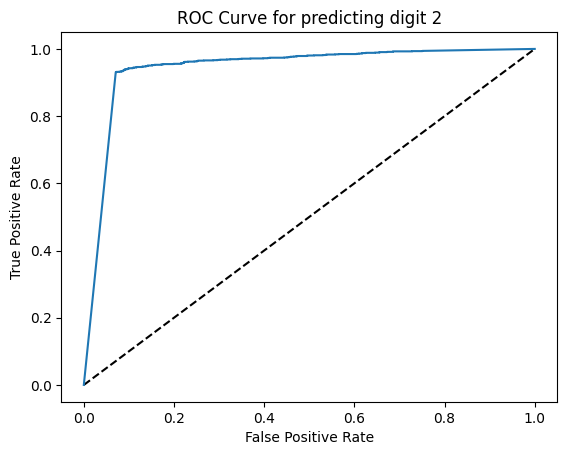

In [170]:
fpr, tpr, thresholds = roc_curve(y_val_2, y_pred_2_probs)
plt.plot([0, 1], [0, 1], 'k--')

# plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for predicting digit 2')
plt.show()

In [29]:
print(roc_auc_score(y_val_2, y_pred_2_probs))

0.9422609108910891


In [30]:
print(confusion_matrix(y_val_2, y_pred_2))

[[12531    94]
 [  190  1185]]


In [173]:
print(classification_report(y_val_2, y_pred_2))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99     12625
        True       0.93      0.86      0.89      1375

    accuracy                           0.98     14000
   macro avg       0.96      0.93      0.94     14000
weighted avg       0.98      0.98      0.98     14000



In [31]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
params = {"penalty": ["l1", "l2"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": np.linspace(0.1, 1.0, 50),
         "class_weight": ["balanced", {0:0.8, 1:0.2}]}

logreg_cv = RandomizedSearchCV(logreg, params, cv=kf)


In [32]:
logreg_cv.fit(X_train_scaled, y_train_2)

c:\Users\makpe\.virtualenvs\Machine_Learning-2CwZjeYm\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\makpe\.virtualenvs\Machine_Learning-2CwZjeYm\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(),
                   param_distributions={'C': array([0.1       , 0.11836735, 0.13673469, 0.15510204, 0.17346939,
       0.19183673, 0.21020408, 0.22857143, 0.24693878, 0.26530612,
       0.28367347, 0.30204082, 0.32040816, 0.33877551, 0.35714286,
       0.3755102 , 0.39387755, 0.4122449 , 0.43061224, 0.44897959,
       0.46734...
       4.89846939e-01, 5.10253061e-01, 5.30659184e-01, 5.51065306e-01,
       5.71471429e-01, 5.91877551e-01, 6.12283673e-01, 6.32689796e-01,
       6.53095918e-01, 6.73502041e-01, 6.93908163e-01, 7.14314286e-01,
       7.34720408e-01, 7.55126531e-01, 7.75532653e-01, 7.95938776e-01,
       8.16344898e-01, 8.36751020e-01, 8.57157143e-01, 8.77563265e-01,
       8.97969388e-01, 9.18375510e-01, 9.38781633e-01, 9.59187755e-01,
       9.79593878e-01, 1.00000000e+00])})

In [33]:
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Best Accuracy Score: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'tol': 0.34700408163265306, 'penalty': 'l2', 'class_weight': {0: 0.8, 1: 0.2}, 'C': 0.5775510204081633}
Tuned Logistic Regression Best Accuracy Score: 0.9759285714285714


In [34]:
test_score = logreg_cv.score(X_val_scaled, y_val_2)
print(test_score)

0.9777142857142858


The score on the evaluation set is slightly lower than that of the training data (which came out at 0.86).

In [77]:
y_pred_cv = logreg_cv.predict(X_val_scaled)
print(confusion_matrix(y_val_2, y_pred_cv))

[[12588    37]
 [  275  1100]]


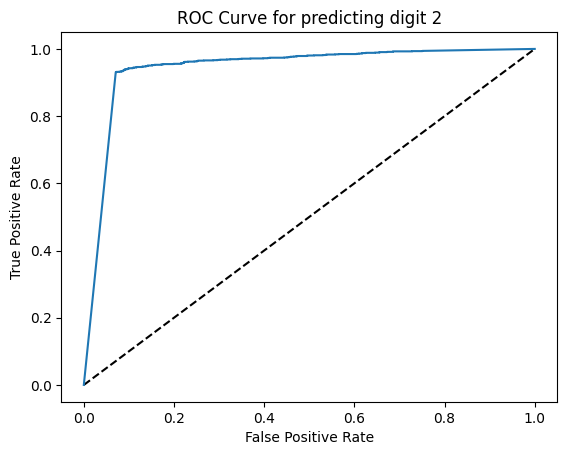

In [78]:
y_pred_cv = logreg.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val_2, y_pred_cv)
plt.plot([0, 1], [0, 1], 'k--')

# plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for predicting digit 2')
plt.show()

In [81]:
print(roc_auc_score(y_val_2, y_pred_cv))

0.9422609108910891


The results are interesting compared to the standard Logistic Regression; the False Negatives are nearly 50% higher after  hyperparameter tuning but, on the other hand, the False Negatives were more than halved (from 245 to 107), showing that after tuning the model was much more willing to assign an observation a '2' label. This is another example of the balance between accuracy and recall.

# Random Forest Classifier

In [38]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_2, cv=3, method="predict_proba")


In [39]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_2, y_scores_forest)

In [40]:
roc_auc_score(y_train_2, y_scores_forest)

0.9976571793095029

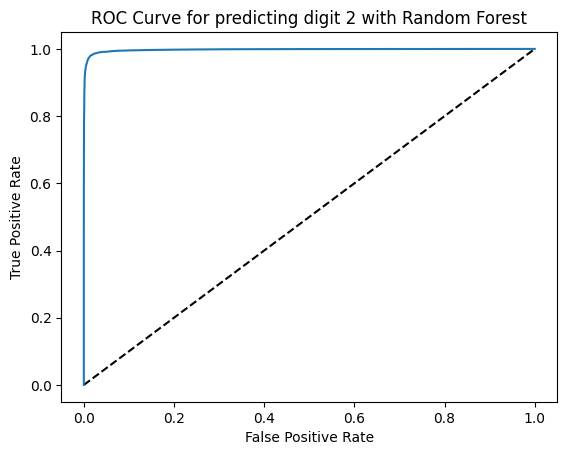

In [41]:
plt.plot([0, 1], [0, 1], 'k--')

# plot tpr against fpr
plt.plot(fpr_forest, tpr_forest)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for predicting digit 2 with Random Forest')
plt.show()

In [103]:
rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rfc_search = GridSearchCV(rfc, param_grid, cv=5)

rfc_search.fit(X_train, y_train_2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]})

The above runtime was considerably more than I had bargained for, though I clearly added more hyperparameter options than was wise in one search

In [50]:
rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [60, 80, 100]
}

rfc_search = GridSearchCV(rfc, param_grid, cv=3)

rfc_search.fit(X_train, y_train_2)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': [60, 80, 100]})

In [51]:
print(rfc_search.best_params_)

{'n_estimators': 100}


In [105]:
print(rfc_search.best_params_)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [52]:
rfc_2 = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=1, min_samples_split=2, random_state=42)

rfc_2.fit(X_train, y_train_2)

RandomForestClassifier(max_depth=20, random_state=42)

In [122]:
y_pred_rfc = rfc_search.predict(X_val)

In [123]:
print(accuracy_score(y_val_2, y_pred_rfc))

0.987


In [124]:
print(confusion_matrix(y_val_2, y_pred_rfc))

[[12611    14]
 [  168  1207]]


In [129]:
print(classification_report(y_val_2, y_pred_rfc))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99     12625
        True       0.99      0.88      0.93      1375

    accuracy                           0.99     14000
   macro avg       0.99      0.94      0.96     14000
weighted avg       0.99      0.99      0.99     14000



In [161]:
print(precision_score(y_val_2, y_pred_rfc))

0.9885339885339886


In [53]:
y_pred_rfc_2 = rfc_2.predict(X_val)

In [54]:
print(accuracy_score(y_val_2, y_pred_rfc_2))

0.987


# K Nearest Neighbors

In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
params_knn = {'n_neighbors': [2, 3, 5, 7, 9]}

In [43]:
knn_grid = GridSearchCV(knn, params_knn, cv=5, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train_2)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 5, 7, 9]}, scoring='accuracy')

In [44]:
print('Best hyperparameters: ', knn_grid.best_params_)
print('Best accuracy: ', knn_grid.best_score_)

Best hyperparameters:  {'n_neighbors': 3}
Best accuracy:  0.9885952380952382


In [45]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train_2)
y_pred_knn = knn.predict(X_val)

I repeated the fit with the best score for nearest neighbours mainly for my own curiousity, to be certain that predicted values equate to those that the gridsearch has calculated.

In [46]:
accuracy_knn = accuracy_score(y_val_2, y_pred_knn)
print("Accuracy:", accuracy_knn)
precision_knn = precision_score(y_val_2, y_pred_knn)
print("Precision:", precision_knn)

Accuracy: 0.9778571428571429
Precision: 0.941908713692946


## Decision Trees

In [47]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train_2)

DecisionTreeClassifier()

In [48]:
y_pred_tree = tree.predict(X_val)
accuracy_tree = accuracy_score(y_val_2, y_pred_tree)
print('Accuracy: ', accuracy_tree)
print(confusion_matrix(y_val_2, y_pred_tree))

Accuracy:  0.9721428571428572
[[12434   191]
 [  199  1176]]


In [49]:
print(classification_report(y_val_2, y_pred_tree))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98     12625
        True       0.86      0.86      0.86      1375

    accuracy                           0.97     14000
   macro avg       0.92      0.92      0.92     14000
weighted avg       0.97      0.97      0.97     14000



# Final Testing against New Data - Test Set

## Linear SVC

In [182]:
y_pred_lin = lin_clf.predict(X_test_scaled)
accuracy_lvc_test = accuracy_score(y_test, y_pred_lin)
print('Accuracy: ', accuracy_lvc_test)

Accuracy:  0.8690714285714286


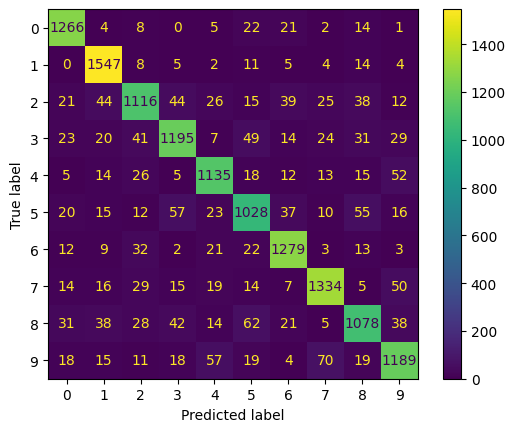

In [183]:
display_confusion_matrix(y_test, y_pred_lin)

## SVC (Support Vector Classification)

In [37]:
y_pred = svm_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy: ', accuracy)

accuracy:  0.9596428571428571


## SGD Classifier

In [61]:
y_test_pred = cross_val_predict(sgd_clf, X_test, y_test_2, cv=3)
print(confusion_matrix(y_test_2, y_test_pred))

[[12251   369]
 [  231  1149]]


In [63]:
print(classification_report(y_test_2, y_test_pred))

              precision    recall  f1-score   support

       False       0.98      0.97      0.98     12620
        True       0.76      0.83      0.79      1380

    accuracy                           0.96     14000
   macro avg       0.87      0.90      0.88     14000
weighted avg       0.96      0.96      0.96     14000



In [64]:
print(accuracy_score(y_test_2, y_test_pred))

0.9571428571428572


## Logistic Regression

In [65]:
y_pred_t = logreg.predict(X_test_scaled)
print(confusion_matrix(y_test_2, y_pred_t))

[[12514   106]
 [  195  1185]]


In [66]:
print(classification_report(y_test_2, y_pred_t))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99     12620
        True       0.92      0.86      0.89      1380

    accuracy                           0.98     14000
   macro avg       0.95      0.93      0.94     14000
weighted avg       0.98      0.98      0.98     14000



In [67]:
print(accuracy_score(y_test_2, y_pred_t))

0.9785


## Logistic Regression (after hyperperameter tuning)

In [68]:
y_pred = logreg_cv.predict(X_test_scaled)
print(confusion_matrix(y_test_2, y_pred))

[[12578    42]
 [  279  1101]]


In [69]:
print(classification_report(y_test_2, y_pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     12620
        True       0.96      0.80      0.87      1380

    accuracy                           0.98     14000
   macro avg       0.97      0.90      0.93     14000
weighted avg       0.98      0.98      0.98     14000



In [70]:
print(accuracy_score(y_test_2, y_pred))

0.9770714285714286


## Decision Trees

In [75]:
y_pred_tree_t = tree.predict(X_test)
accuracy_tree_t = accuracy_score(y_test_2, y_pred_tree_t)
print('Accuracy: ', accuracy_tree_t)
print(confusion_matrix(y_test_2, y_pred_tree_t))
print(classification_report(y_test_2, y_pred_tree_t))

Accuracy:  0.9702857142857143
[[12403   217]
 [  199  1181]]
              precision    recall  f1-score   support

       False       0.98      0.98      0.98     12620
        True       0.84      0.86      0.85      1380

    accuracy                           0.97     14000
   macro avg       0.91      0.92      0.92     14000
weighted avg       0.97      0.97      0.97     14000



## Random Forest Classifier

In [71]:
y_pred_rfc_t = rfc_2.predict(X_test)
accuracy_rfc = accuracy_score(y_test_2, y_pred_rfc_t)
print('Accuracy: ', accuracy_rfc)
print(confusion_matrix(y_test_2, y_pred_rfc_t))
print(classification_report(y_test_2, y_pred_rfc_t))

Accuracy:  0.9887857142857143
[[12604    16]
 [  141  1239]]
              precision    recall  f1-score   support

       False       0.99      1.00      0.99     12620
        True       0.99      0.90      0.94      1380

    accuracy                           0.99     14000
   macro avg       0.99      0.95      0.97     14000
weighted avg       0.99      0.99      0.99     14000



## K Nearest Neighbours

In [72]:
y_pred_knn_t = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test_2, y_pred_knn_t)
print('Accuracy: ', accuracy_knn)
print(confusion_matrix(y_test_2, y_pred_knn_t))
print(classification_report(y_test_2, y_pred_knn_t))

Accuracy:  0.9756428571428571
[[12545    75]
 [  266  1114]]
              precision    recall  f1-score   support

       False       0.98      0.99      0.99     12620
        True       0.94      0.81      0.87      1380

    accuracy                           0.98     14000
   macro avg       0.96      0.90      0.93     14000
weighted avg       0.98      0.98      0.97     14000

